In [395]:
%matplotlib inline

import fipy as fp
import fipy.tools.numerix as numerix

In [411]:
nx = 200
ny = 200
dx = 0.1
dy = 0.1
mesh = fp.Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)

In [412]:
mm = 4
epsilon_m = 0.025
theta_0 = 0.0
tau_0 = 1.
DD = 10.
W_0 = 1.
lamda = DD * tau_0 / 0.6267 / W_0**2
delta = 0.05

In [413]:
phase = fp.CellVariable(mesh=mesh, hasOld=True)
uu = fp.CellVariable(mesh=mesh, hasOld=True)
uu.constrain(-delta, mesh.exteriorFaces)
dt = fp.Variable(1.0)

In [414]:
def initialize():
    phase[:] = -1.0
    x, y = mesh.cellCenters
    radius = 2.0
    center = (nx * dx / 2., ny * dy / 2.)
    mask = (x - center[0])**2 + (y - center[1])**2 < radius**2
    phase.setValue(1., where=mask)
    uu[:] = -delta
    dt = fp.Variable(0.1)
initialize()

In [415]:
def make_tau(phase_):
    theta_cell = numerix.arctan2(phase_.grad[1], phase_.grad[0])
    a_cell = 1 + epsilon_m * numerix.cos(mm * theta_cell - theta_0)
    return tau_0 * a_cell**2

tau = make_tau(phase)
tau_old = make_tau(phase.old)

In [416]:
# source_explicit = 2 * phase**3 - lamda * uu * (1 - phase**2) * (1 + 3 * phase**2)
# source_implicit = (1 - 3 * phase**2) + 4 * lamda * uu * phase * (1 - phase**2)
source = (phase - lamda * uu * (1 - phase**2)) * (1 - phase**2)

In [417]:
theta = numerix.arctan2(phase.faceGrad[1], phase.faceGrad[0])
W = W_0 * (1 + epsilon_m * numerix.cos(mm * theta - theta_0))

W_theta = - W_0 * mm * epsilon_m * numerix.sin(mm * theta - theta_0)

I0 = fp.Variable(value=((1,0), (0,1)))
I1 = fp.Variable(value=((0,-1), (1,0)))

Dphase = W**2 * I0 + W * W_theta * I1

In [418]:
heat_eqn = fp.TransientTerm() == fp.DiffusionTerm(DD) + (phase - phase.old) / dt / 2.

phase_eqn = fp.TransientTerm(tau) == fp.DiffusionTerm(Dphase) + source #source_explicit + \
#            fp.ImplicitSourceTerm(source_implicit) #+ fp.ImplicitSourceTerm((tau - tau_old) / dt)

In [419]:
print max(tau), min(tau)

1.050625 0.950625


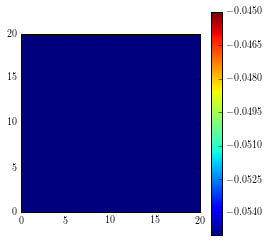

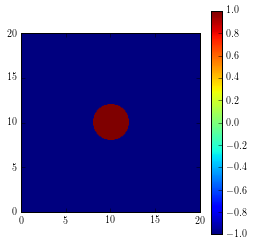

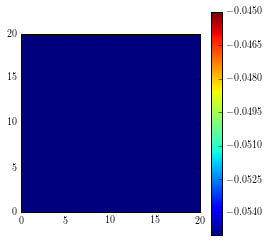

In [420]:
phase_viewer = fp.Viewer(phase)
uu_viewer = fp.Viewer(uu)
phase_viewer.plot()
uu_viewer.plot()

In [421]:
print tau_old

[ 1.050625  1.050625  1.050625 ...,  1.050625  1.050625  1.050625]


In [422]:
print dt


1.0


In [423]:
initialize()
dt.setValue(0.01)
total_steps = 40
sweeps = 5
tolerance = 1e-1
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver_heat = Solver()
solver_phase = Solver()

current_step = 0
while current_step < total_steps:
    uu.updateOld()
    phase.updateOld()

    res_heat0 = heat_eqn.sweep(uu, dt=dt.value, solver=solver_heat)
    res_phase0 = phase_eqn.sweep(phase, dt=dt.value, solver=solver_phase)

    for sweep in range(sweeps):
        res_heat = heat_eqn.sweep(uu, dt=dt.value, solver=solver_heat)
        res_phase = phase_eqn.sweep(phase, dt=dt.value, solver=solver_phase)

    
    print
    print 'dt',dt.value    
    print 'current_step',current_step
    print 'res_heat',res_heat0, res_heat
    print 'res_phase',res_phase0, res_phase
    if (res_heat < res_heat0 * tolerance) and (res_phase < res_phase0 * tolerance):
        current_step += 1
        dt.setValue(dt.value * 1.1)
    else:
        dt.setValue(dt.value * 0.8)
        uu[:] == uu.old
        phase[:] = phase.old




dt 0.01
current_step 0
res_heat 5.12246744012e-14 0.000193600507553
res_phase 46.4504796618 0.000340346258822

dt 0.008
current_step 0
res_heat 4.73847766591 0.000182303426981
res_phase 46.4504796618 0.000257398344962

dt 0.0088
current_step 1
res_heat 5.76736128476 0.000154897875628
res_phase 11.7290173176 0.000267805568792

dt 0.00968
current_step 2
res_heat 2.49022801312 5.3431779284e-05
res_phase 4.7697781259 7.4085208658e-05

dt 0.010648
current_step 3
res_heat 1.51964644457 2.28661156707e-05
res_phase 2.91008809545 2.68730086596e-05

dt 0.0117128
current_step 4
res_heat 1.09960984469 1.25311217348e-05
res_phase 2.10871421742 1.52712492916e-05

dt 0.01288408
current_step 5
res_heat 0.857458182505 6.791155319e-06
res_phase 1.64688293207 9.21308928549e-06

dt 0.014172488
current_step 6
res_heat 0.696379551584 3.95901141629e-06
res_phase 1.3397403319 4.93913613555e-06

dt 0.0155897368
current_step 7
res_heat 0.580290959008 3.5346127151e-06
res_phase 1.11811847513 2.74118307185e-06



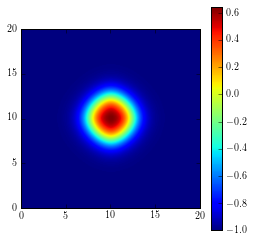

In [424]:
phase_viewer.plot()

In [335]:
print phase

[ 1.  1.  1. ...,  1.  1.  1.]


In [ ]:
from fipy.tools impor